# Galaxy vs Quasar

### WIP - Unfinished!!

In [69]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, roc_curve)

import corner
from astropy.io import ascii

plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['font.size'] = 12
#plt.rcParams['figure.dpi'] = 300

In [70]:
data = ascii.read('../solutions/galaxyquasar.csv', header_start=0)

In [71]:
data

u,g,r,i,z,class,z1,zerr
float64,float64,float64,float64,float64,str6,float64,float64
18.97213,18.53676,18.5828,18.34936,18.29215,QSO,0.5228189,0.0001547483
19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.1228459,2.816076e-05
19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.0,0.0
19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.1474355,9.310701e-06
19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.0006307968
17.60994,15.90911,15.0209,14.54955,14.19971,GALAXY,0.04619161,1.022329e-05
18.50014,17.42286,17.03657,16.76236,16.63258,GALAXY,0.0516851,6.667251e-06
19.53253,19.49823,19.42254,19.07912,18.90426,QSO,1.88844,0.0005242734
19.37014,17.94086,17.154,16.74367,16.42825,GALAXY,0.137445,1.284492e-05


In [72]:
u_g = (data['u'] - data['g'])[:, None]
g_r = (data['g'] - data['r'])[:, None]
r_i = (data['r'] - data['i'])[:, None]
i_z = (data['i'] - data['z'])[:, None]

kind = []

for i in data['class']:
    if i == 'QSO':  #Quasar Label
        kind.append(1)
    elif i == 'GALAXY':     #Galaxy label
        kind.append(0)

kind = np.array(kind)

In [73]:
fast_kind = np.where(data['class'] == 'QSO', 1, 0)

In [74]:
fast_kind

array([1, 0, 0, ..., 0, 0, 0])

In [75]:
fast_kind.shape

(50000,)

In [76]:
classifier = GaussianNB()

tofit = np.column_stack([u_g, g_r, r_i, i_z])


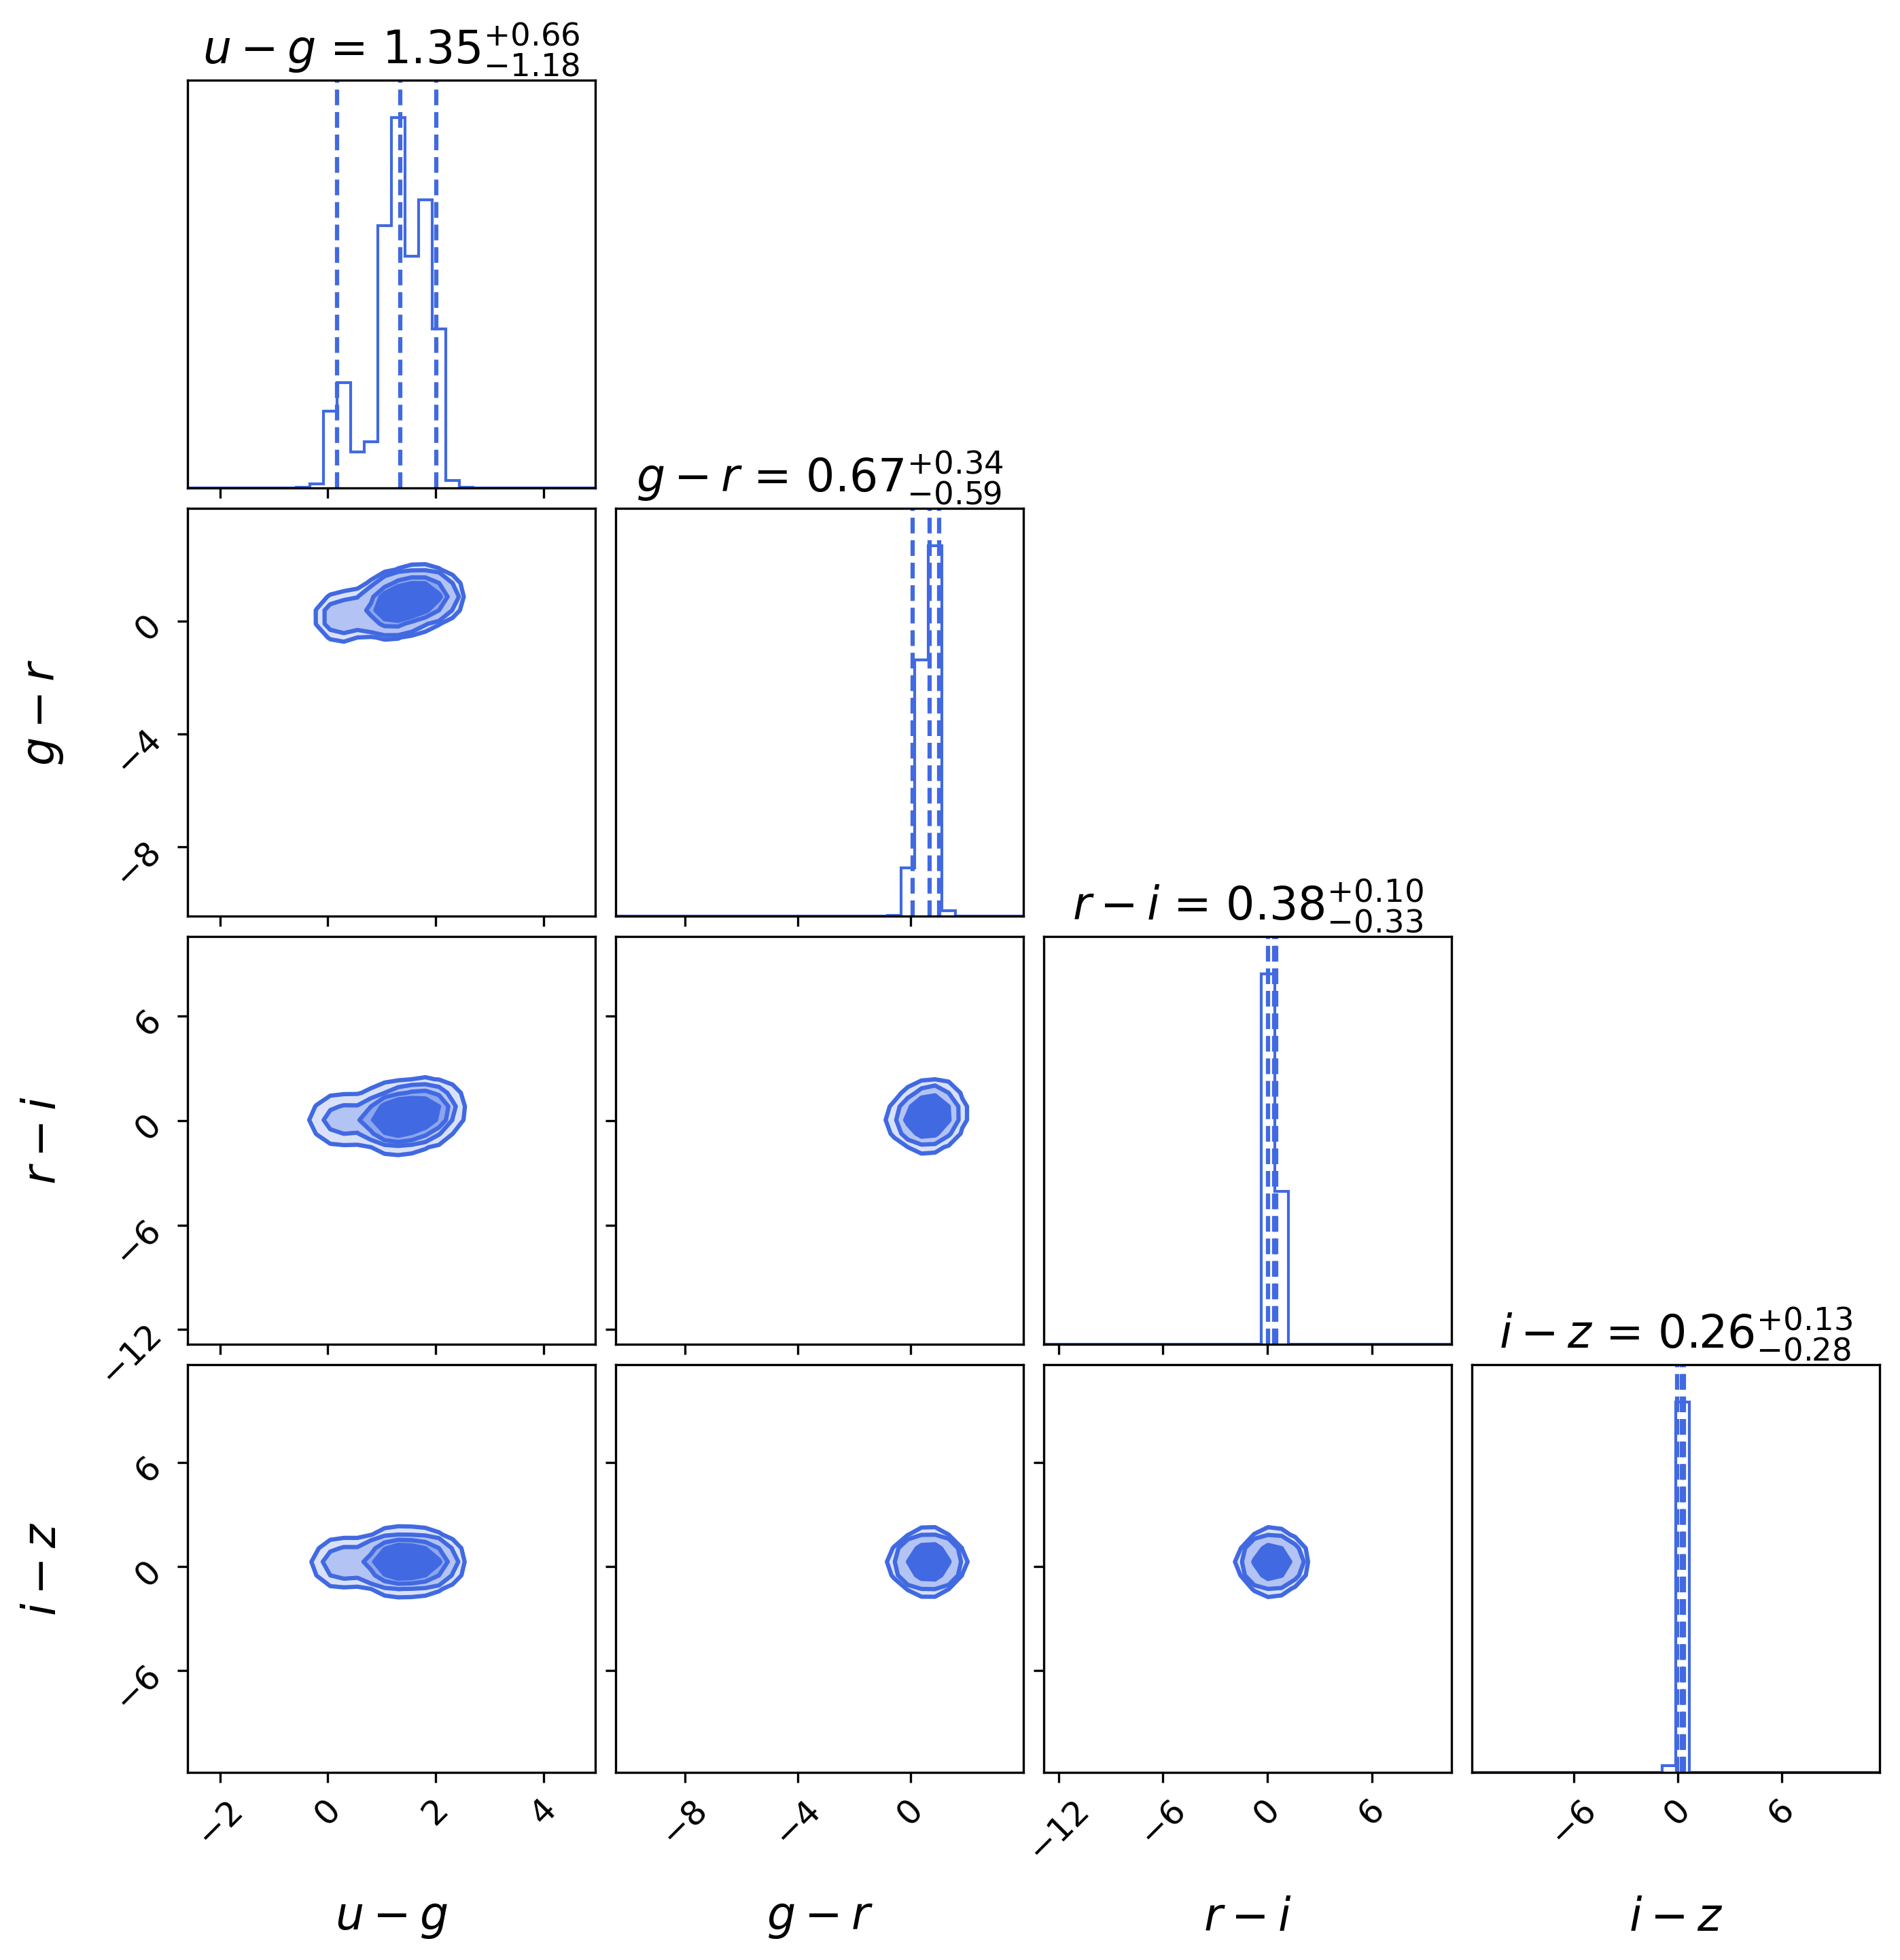

In [77]:
labels = [r"$u-g$", r"$g-r$", r"$r-i$", r"$i-z$"]

#Pretty-plotting arguments for corner plots
CORNER_KWARGS = dict(
    smooth = 1,
    label_kwargs = dict(fontsize=16),
    title_kwargs = dict(fontsize=16),
    bins = 30,
    labels = labels,
    quantiles = [0.05, 0.50, 0.95],
    levels = [0.50, 0.68, 0.85, 0.95],
    color = 'royalblue',
    plot_density = False,
    plot_datapoints = False,
    fill_contours = True,
    show_titles = True,
    max_n_ticks = 4
)

corner.corner(tofit, **CORNER_KWARGS);

(array([5.28516085e-05, 0.00000000e+00, 1.05703217e-04, 2.11406434e-04,
        1.58554826e-04, 1.16273539e-03, 3.85816742e-02, 2.70811642e-01,
        8.63595284e-02, 4.87344682e-01, 8.23110951e-01, 6.55201391e-01,
        2.74458403e-01, 3.22394812e-03, 4.22812868e-04, 4.75664477e-04,
        4.22812868e-04, 2.64258043e-04, 5.28516085e-05, 1.58554826e-04]),
 array([-2.6037  , -2.225282, -1.846864, -1.468446, -1.090028, -0.71161 ,
        -0.333192,  0.045226,  0.423644,  0.802062,  1.18048 ,  1.558898,
         1.937316,  2.315734,  2.694152,  3.07257 ,  3.450988,  3.829406,
         4.207824,  4.586242,  4.96466 ]),
 <BarContainer object of 20 artists>)

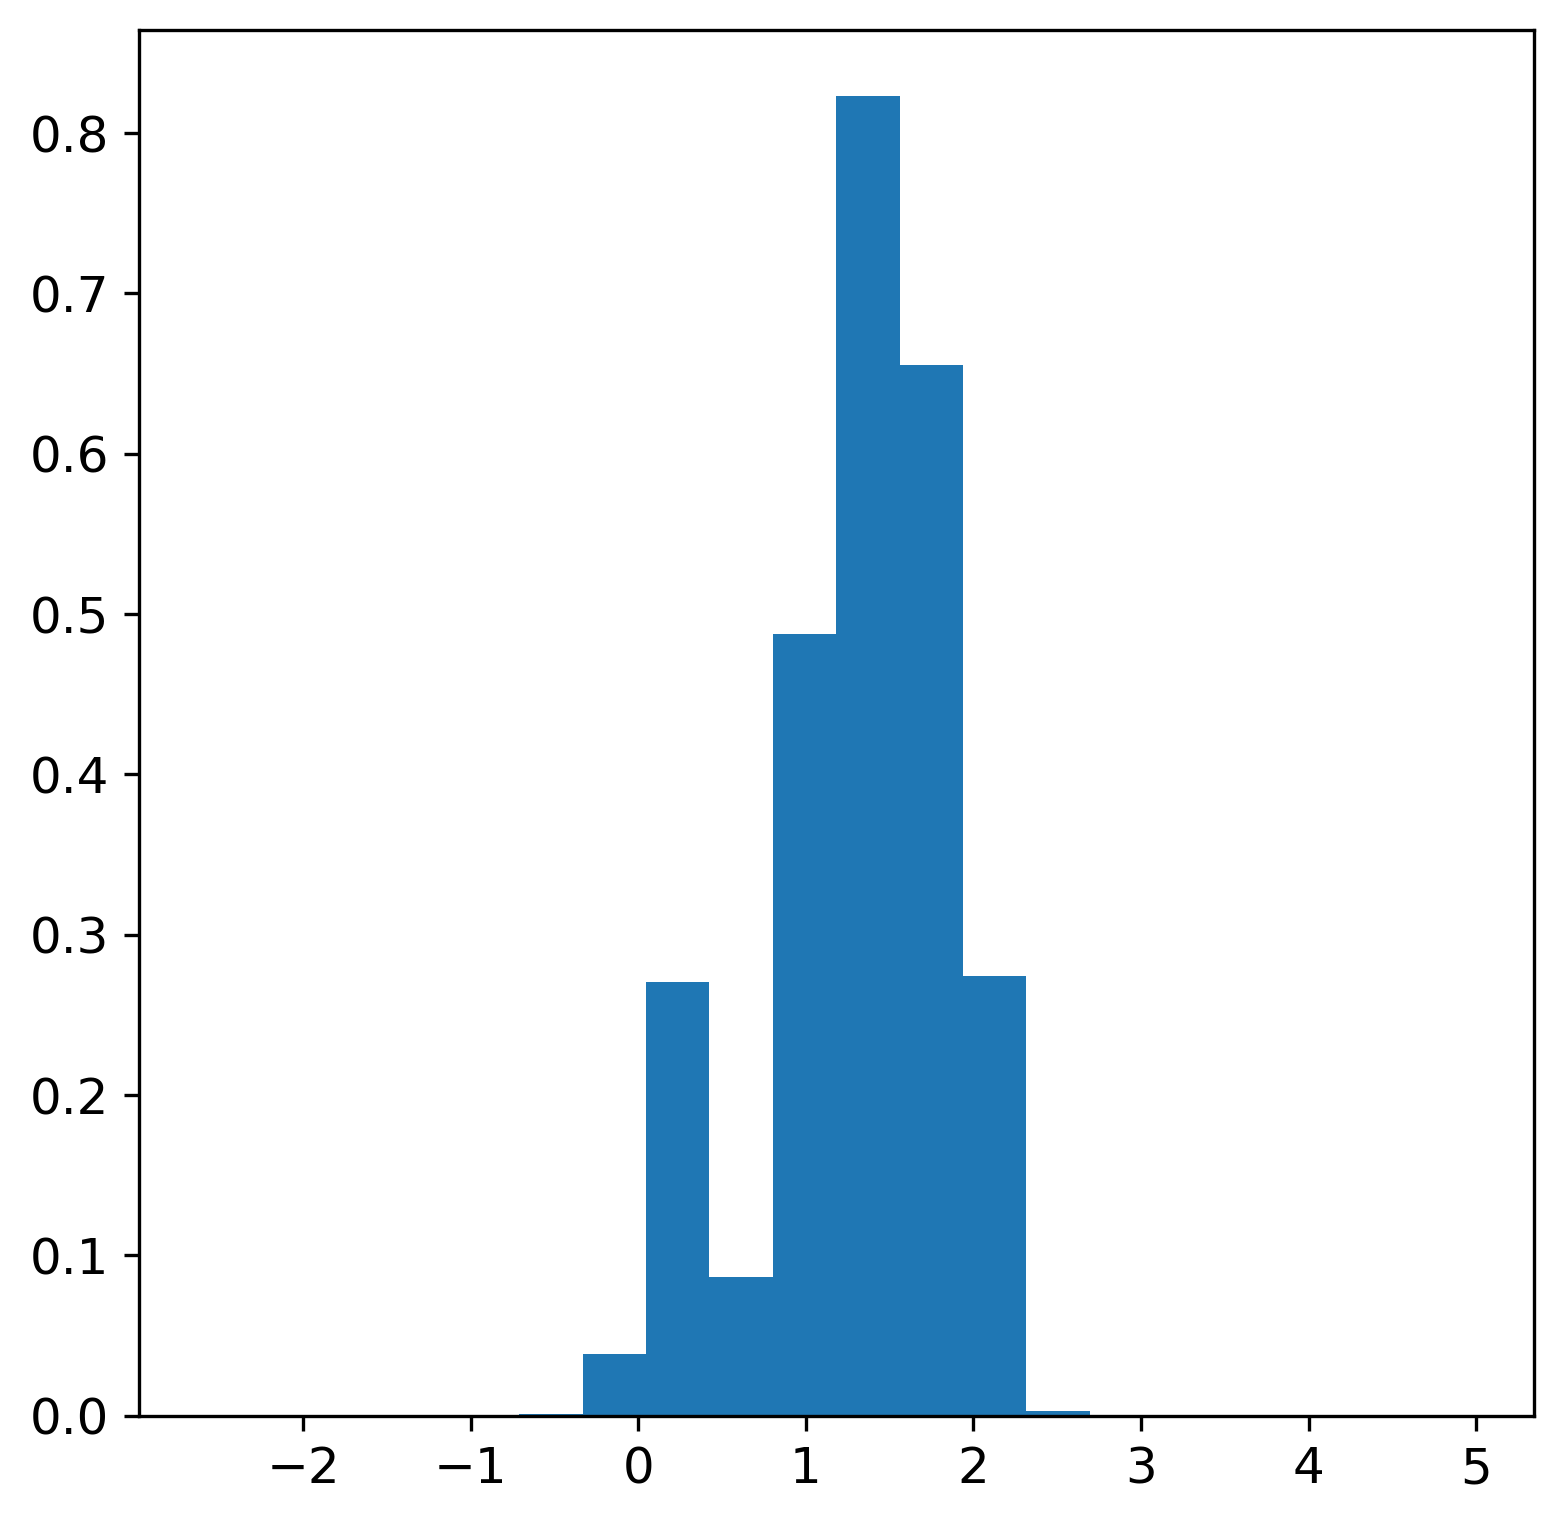

In [78]:
plt.hist(u_g, bins=20, density=True)

In [79]:


xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(tofit, fast_kind, test_size = 0.75)

classifier.fit(xtrain, ytrain)
result = classifier.predict(xtest)


result.shape

(37500,)